<a href="https://colab.research.google.com/github/cjkreienkamp/machine-learning-notebooks/blob/main/03_tabular_data_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [9]:
import sys
import cv2
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data preparation

In [3]:
!pip install openml > /dev/null
!pip install category_encoders > /dev/null

In [3]:
import openml
import pandas as pd

# Dataset ID from OpenML
dataset_id = 42729

# Load dataset
dataset = openml.datasets.get_dataset(dataset_id)

# Convert to Pandas DataFrame
df, _, _, _ = dataset.get_data()

# Display dataset information
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581835 entries, 0 to 581834
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   VendorID                      581835 non-null  category
 1   store_and_fwd_flag            581835 non-null  category
 2   RatecodeID                    581835 non-null  category
 3   PULocationID                  581835 non-null  category
 4   DOLocationID                  581835 non-null  category
 5   passenger_count               581835 non-null  uint8   
 6   extra                         581835 non-null  category
 7   mta_tax                       581835 non-null  category
 8   tip_amount                    581835 non-null  float64 
 9   tolls_amount                  581835 non-null  float64 
 10  improvement_surcharge         581835 non-null  category
 11  total_amount                  581835 non-null  float64 
 12  trip_type                     

In [16]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categories_dict = {col: df[col].unique().tolist() for col in categorical_columns}
print(categories_dict)

{'VendorID': ['2', '1'], 'store_and_fwd_flag': ['N', 'Y'], 'RatecodeID': ['1', '5', '2', '3', '4'], 'PULocationID': ['92', '75', '166', '42', '65', '256', '95', '244', '223', '25', '7', '74', '41', '255', '82', '168', '49', '225', '247', '130', '127', '43', '80', '260', '129', '250', '17', '78', '97', '189', '181', '193', '63', '116', '112', '33', '53', '40', '36', '183', '134', '242', '69', '66', '61', '182', '179', '226', '243', '196', '52', '106', '254', '37', '145', '72', '83', '173', '212', '146', '24', '216', '56', '89', '192', '71', '152', '85', '188', '190', '217', '198', '197', '62', '258', '28', '264', '263', '23', '91', '169', '174', '185', '132', '177', '195', '157', '39', '54', '120', '210', '18', '159', '257', '236', '138', '34', '167', '248', '265', '155', '136', '241', '147', '47', '202', '235', '222', '228', '81', '153', '70', '20', '94', '119', '29', '200', '32', '133', '165', '35', '55', '220', '213', '149', '76', '123', '184', '121', '171', '131', '60', '31', '10', 

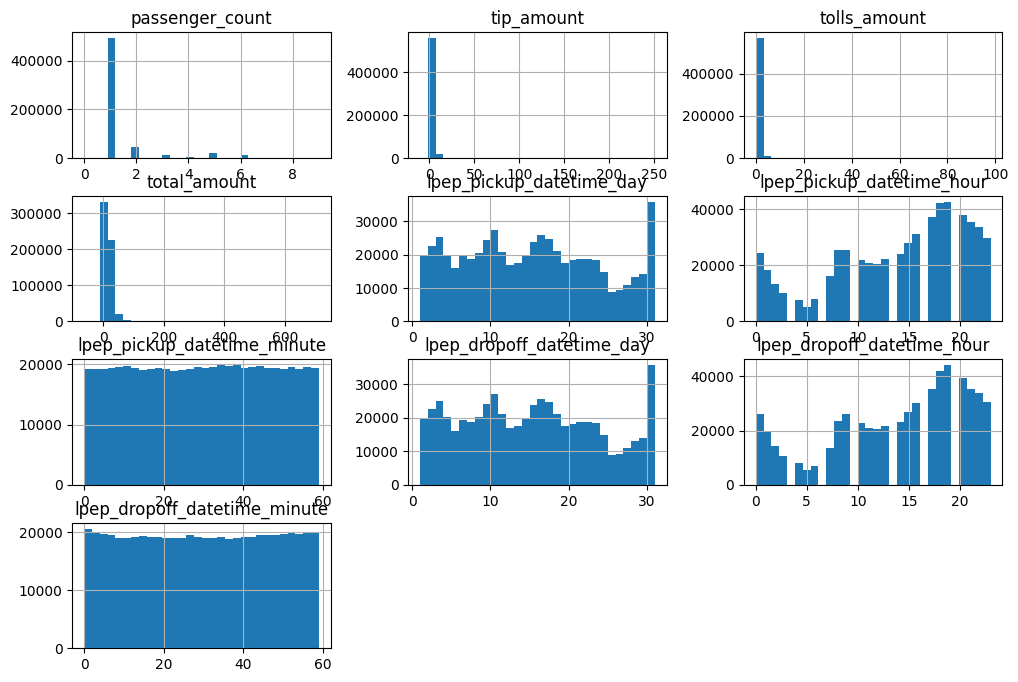

In [12]:
df.hist(figsize=(12,8), bins=30)
plt.show()

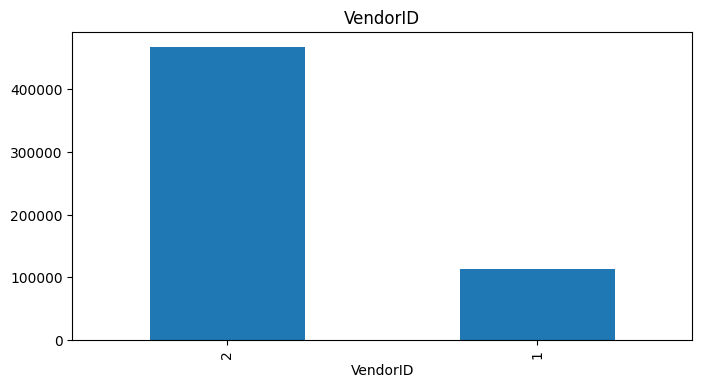

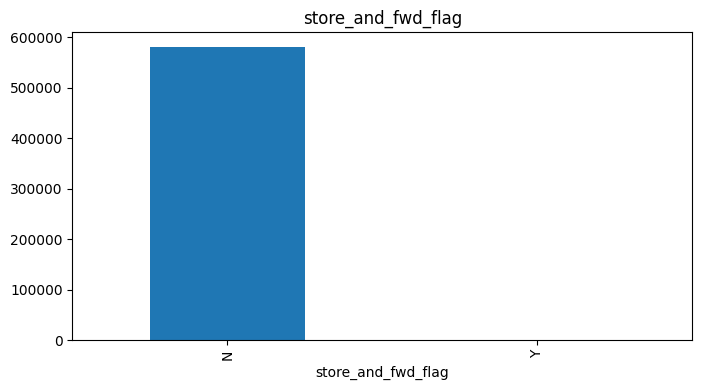

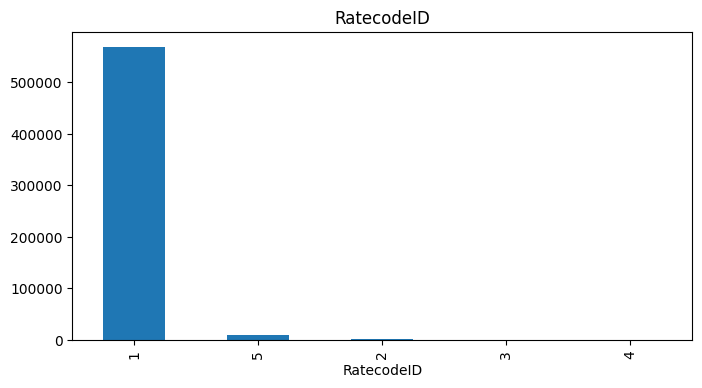

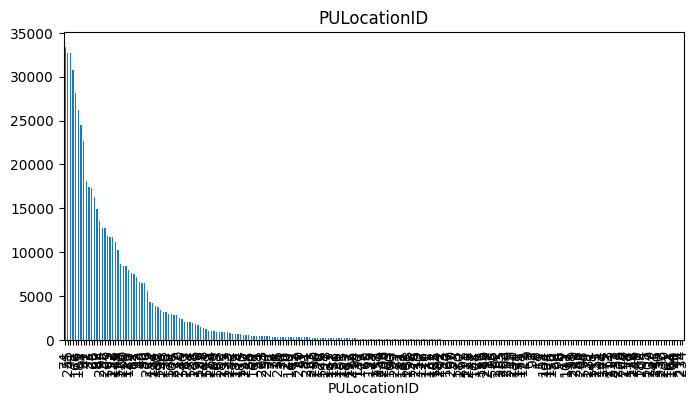

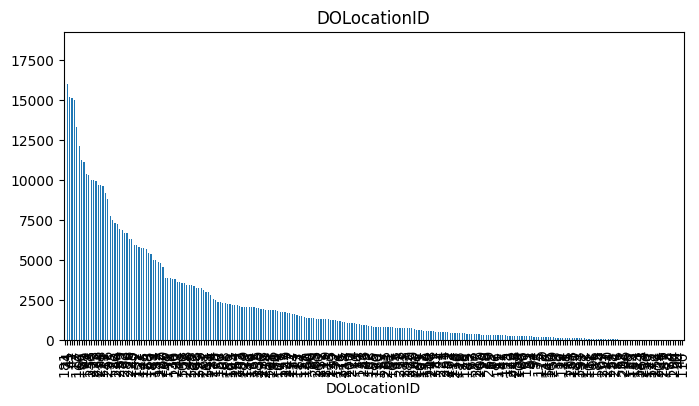

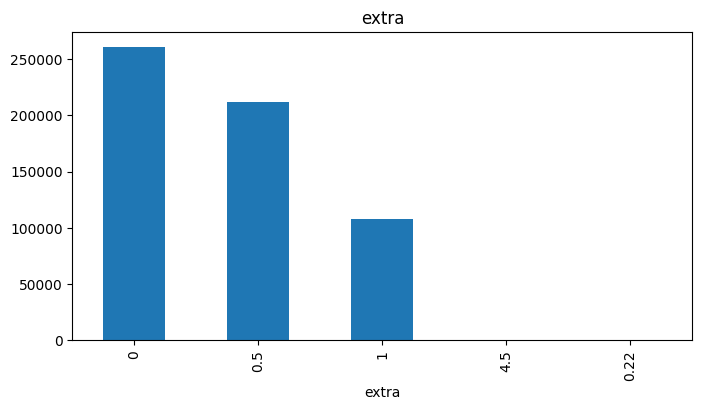

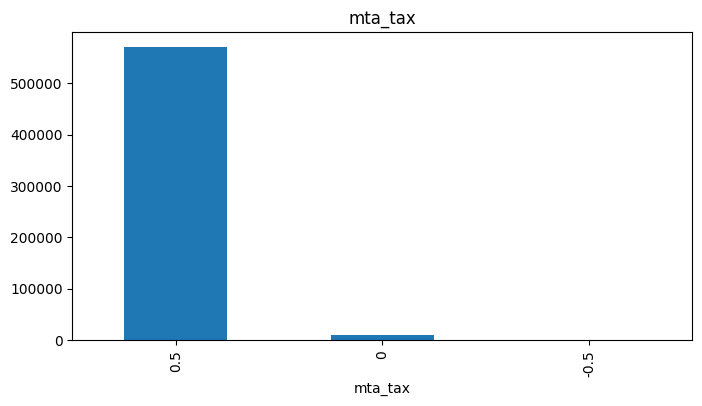

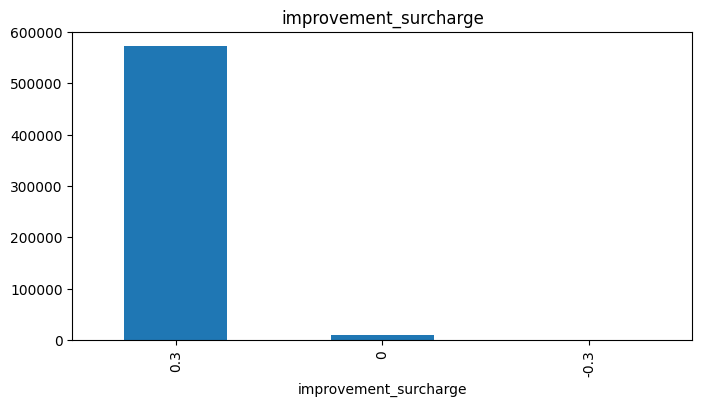

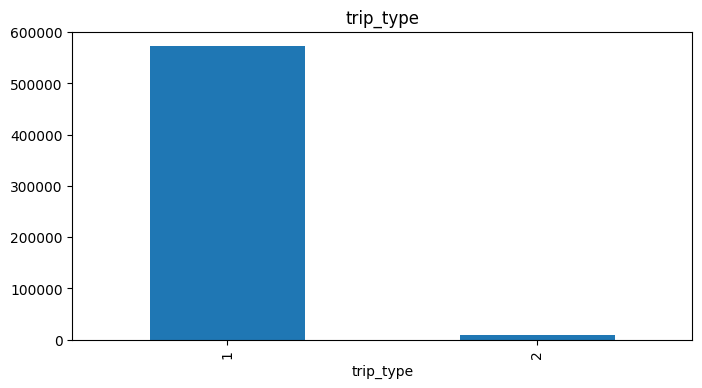

In [17]:
for col in df.select_dtypes(include=['object', 'category']):
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()


In [29]:
df.select_dtypes(include=['category']).columns

Index(['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'extra', 'mta_tax', 'improvement_surcharge',
       'trip_type'],
      dtype='object')

In [27]:
df.select_dtypes(include=['float64']).columns

Index(['tip_amount', 'tolls_amount', 'total_amount'], dtype='object')

In [28]:
df.select_dtypes(include=['uint8']).columns

Index(['passenger_count', 'lpep_pickup_datetime_day',
       'lpep_pickup_datetime_hour', 'lpep_pickup_datetime_minute',
       'lpep_dropoff_datetime_day', 'lpep_dropoff_datetime_hour',
       'lpep_dropoff_datetime_minute'],
      dtype='object')

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders.target_encoder import TargetEncoder

cols_to_drop = ['total_amount', 'store_and_fwd_flag']
numeric_cols_minmax = ['lpep_pickup_datetime_day', 'lpep_pickup_datetime_hour', 'lpep_pickup_datetime_minute',
    'lpep_dropoff_datetime_day', 'lpep_dropoff_datetime_hour', 'lpep_dropoff_datetime_minute']
numeric_cols_zscore = ['passenger_count', 'tolls_amount']
low_cardinality_cats = ['VendorID', 'RatecodeID',
    'extra', 'mta_tax', 'improvement_surcharge','trip_type']
high_cardinality_cats = ['PULocationID', 'DOLocationID']
target_col = ['tip_amount']

df1 = df.drop(cols_to_drop, axis=1)

minmax_scaler = MinMaxScaler()
df1[numeric_cols_minmax] = pd.DataFrame(minmax_scaler.fit_transform(df1[numeric_cols_minmax]), columns=numeric_cols_minmax)
zscore_scaler = StandardScaler()
df1 = pd.DataFrame(zscore_scaler.fit_transform(df1[numeric_cols_zscore]), columns=numeric_cols_zscore)

df1 = pd.get_dummies(df, columns=low_cardinality_cats, drop_first=True)

target_encoder = TargetEncoder()
df1[high_cardinality_cats] = target_encoder.fit_transform(df1[high_cardinality_cats], df1[target_col])

print(df1.isna().sum())

store_and_fwd_flag              0
PULocationID                    0
DOLocationID                    0
passenger_count                 0
tip_amount                      0
tolls_amount                    0
total_amount                    0
lpep_pickup_datetime_day        0
lpep_pickup_datetime_hour       0
lpep_pickup_datetime_minute     0
lpep_dropoff_datetime_day       0
lpep_dropoff_datetime_hour      0
lpep_dropoff_datetime_minute    0
VendorID_2                      0
RatecodeID_2                    0
RatecodeID_3                    0
RatecodeID_4                    0
RatecodeID_5                    0
extra_0.22                      0
extra_0.5                       0
extra_1                         0
extra_4.5                       0
mta_tax_0                       0
mta_tax_0.5                     0
improvement_surcharge_0         0
improvement_surcharge_0.3       0
trip_type_2                     0
dtype: int64


In [4]:
train_df, temp_df  = train_test_split(df, test_size=0.20, shuffle=True)
valid_df, test_df = train_test_split(temp_df, test_size=0.50, shuffle=True)

In [74]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders.target_encoder import TargetEncoder

class NewYorkTaxiDataset(Dataset):
    def __init__(self, df):

        cols_to_drop = ['total_amount', 'store_and_fwd_flag']
        numeric_cols_minmax = ['lpep_pickup_datetime_day', 'lpep_pickup_datetime_hour', 'lpep_pickup_datetime_minute',
            'lpep_dropoff_datetime_day', 'lpep_dropoff_datetime_hour', 'lpep_dropoff_datetime_minute']
        numeric_cols_zscore = ['passenger_count', 'tolls_amount']
        low_cardinality_cats = ['VendorID', 'RatecodeID',
            'extra', 'mta_tax', 'improvement_surcharge','trip_type']
        high_cardinality_cats = ['PULocationID', 'DOLocationID']
        target_col = ['tip_amount']

        df[numeric_cols_minmax] = pd.DataFrame(MinMaxScaler().fit_transform(df[numeric_cols_minmax]),
                                               index=df.index, columns=numeric_cols_minmax)

        df[numeric_cols_zscore] = pd.DataFrame(StandardScaler().fit_transform(df[numeric_cols_zscore]),
                                               index=df.index, columns=numeric_cols_zscore)

        df = pd.get_dummies(df, columns=low_cardinality_cats, drop_first=True)

        target_encoder = TargetEncoder()
        df[high_cardinality_cats] = target_encoder.fit_transform(df[high_cardinality_cats], df[target_col])

        self.y = df[target_col].values.astype(np.float32)

        df = df.drop(cols_to_drop+target_col, axis=1)

        self.X = df.values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return torch.tensor(self.X[index]), torch.tensor(self.y[index])

In [75]:
train_dataset = NewYorkTaxiDataset(train_df)
valid_dataset = NewYorkTaxiDataset(valid_df)
test_dataset = NewYorkTaxiDataset(test_df)

In [15]:
print(len(train_dataset))

465468


In [81]:
train_dataset[np.random.randint(len(train_dataset))]

(tensor([ 2.7021,  1.9546, -0.3480, -0.1361,  0.2000,  0.8696,  0.9831,  0.2000,
          0.9130,  0.2034,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000]),
 tensor([2.5600]))

# Model training 1


In [50]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
model.fit(train_dataset.X, train_dataset.y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(test_dataset.X)
y_test = test_dataset.y

mse = mean_squared_error(test_dataset.y, y_pred)
rmse = mse ** 0.5  # RMSE is just the square root of MSE
mae = mean_absolute_error(test_dataset.y, y_pred)
r2 = r2_score(test_dataset.y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 5.4648
Root Mean Squared Error (RMSE): 2.3377
Mean Absolute Error (MAE): 1.1294
R² Score: 0.2682


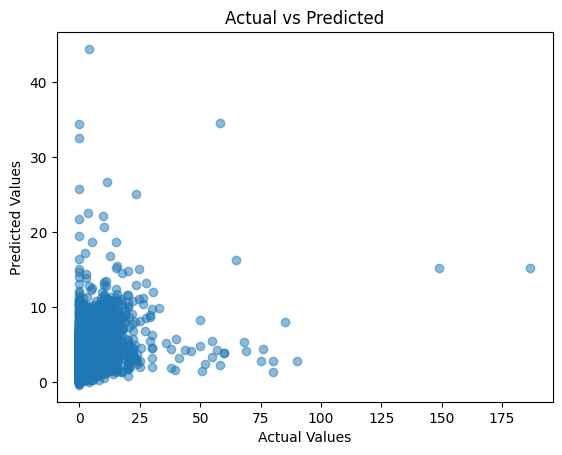

In [52]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

# Model training 2

In [76]:
torch.manual_seed(42)
BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [77]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

for x1, y1 in valid_loader:
    print(x1.shape, y1.shape)
    break

print(len(train_dataset), len(valid_dataset), len(test_dataset))

torch.Size([1024, 24]) torch.Size([1024, 1])
torch.Size([1024, 24]) torch.Size([1024, 1])
465468 58183 58184


In [78]:
class NewYorkTaxiNN(nn.Module):
    def __init__(self, input_size):
        super(NewYorkTaxiNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for x, y in train_loader:
    break
print(f"Input size: {x.shape}")
summary(NewYorkTaxiNN(x.shape[1]), x.shape)

Input size: torch.Size([1024, 24])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1024, 128]           3,200
            Linear-2             [-1, 1024, 64]           8,256
            Linear-3              [-1, 1024, 1]              65
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 1.51
Params size (MB): 0.04
Estimated Total Size (MB): 1.65
----------------------------------------------------------------


In [79]:
def train_fn(data_loader, model, optimizer):

    total_loss = 0.0

    model.train()

    for X, y in data_loader:

        X = X.to(DEVICE)
        y = y.to(DEVICE)

        predictions = model(X)

        loss = nn.MSELoss()(predictions, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):

    total_loss = 0.0

    model.eval()

    with torch.inference_mode():

        for X, y in data_loader:

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            predictions = model(X)

            loss = nn.MSELoss()(predictions, y)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [81]:
EPOCHS = 10
LEARNING_RATE = 0.001

In [71]:
torch.manual_seed(42)
model = NewYorkTaxiNN(x.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

epoch_count, train_loss_values, valid_loss_values = [], [], []
train_acc_values, valid_acc_values = [], []
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

    train_loss = train_fn(train_loader, model, optimizer)
    valid_loss = eval_fn(valid_loader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_valid_loss = valid_loss

    if epoch % int(EPOCHS / 10) == 0:
        print(f"Epoch: {epoch:4.0f} | Train Loss: {train_loss:.5f} | Validation Loss: {valid_loss:.5f}")
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        valid_loss_values.append(valid_loss)


Epoch:    0 | Train Loss: 6.25068 | Validation Loss: 5.52380
Epoch:    1 | Train Loss: 5.96384 | Validation Loss: 5.40185
Epoch:    2 | Train Loss: 5.78426 | Validation Loss: 5.27650
Epoch:    3 | Train Loss: 5.70623 | Validation Loss: 5.22983
Epoch:    4 | Train Loss: 5.60750 | Validation Loss: 5.08897
Epoch:    5 | Train Loss: 5.46639 | Validation Loss: 5.00642
Epoch:    6 | Train Loss: 5.40089 | Validation Loss: 4.99913
Epoch:    7 | Train Loss: 5.37509 | Validation Loss: 4.95159
Epoch:    8 | Train Loss: 5.35454 | Validation Loss: 4.94564
Epoch:    9 | Train Loss: 5.33512 | Validation Loss: 4.92777


# Model evaluation

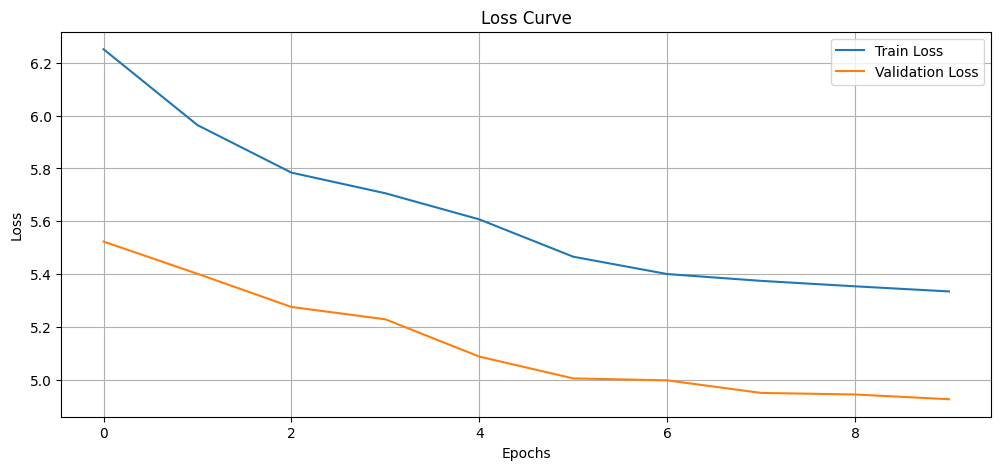

In [72]:
import matplotlib.pyplot as plt

def plot_loss(epoch_count, train_loss_values, valid_loss_values):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Plot Loss Curve
    ax.plot(epoch_count, train_loss_values, label='Train Loss')
    ax.plot(epoch_count, valid_loss_values, label='Validation Loss')
    ax.set_title('Loss Curve')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    plt.show()

# Example Usage
plot_loss(epoch_count, train_loss_values, valid_loss_values)

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model(torch.tensor(test_dataset.X).to(DEVICE)).cpu().detach().numpy()
y_test = test_dataset.y

mse = mean_squared_error(test_dataset.y, y_pred)
rmse = mse ** 0.5  # RMSE is just the square root of MSE
mae = mean_absolute_error(test_dataset.y, y_pred)
r2 = r2_score(test_dataset.y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 5.3230
Root Mean Squared Error (RMSE): 2.3072
Mean Absolute Error (MAE): 1.0853
R² Score: 0.2872


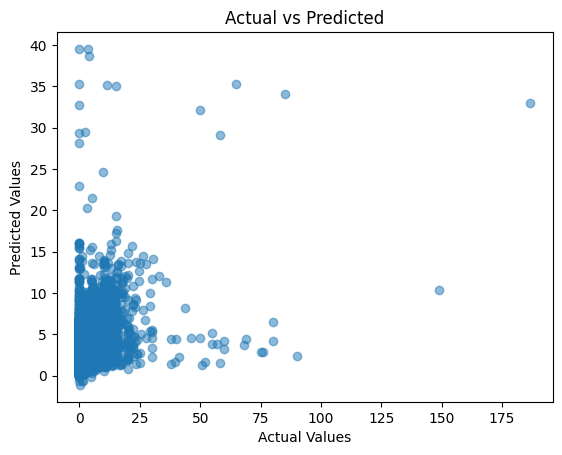

In [67]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()